In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pprint import pprint
import pandas as pd
import os
import cv2 
import imageio
import math
import ExtraFunctions as ef
import itertools
import trackpy as tp
import datetime
import matplotlib.animation as animation
import collections
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform, cdist
from skimage import io
import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence
from scipy.ndimage import gaussian_filter
import tifffile as tiff
import ExtraFunctions as ef
import One_channel as oc
import preprocessing_Alessandro as preA # This file contains the functions to preprocess the images
import plots_Alessandro as plots
import _Alessandro_main_functions as mainf 
import radial_distribution_function as rdf
import structure_factor as sf
import xml.etree.ElementTree as ET 




In [2]:
experiment_path = r"C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_06_24" #path of folder where the analysis will be stored
experiment_name = r"T=33,15to33,65_dm_30_zgap_0,15_after20h9_555" #name of the experiment

z_stack_path = r"C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_06_24"
z_stack_name = r"T=33,15to33,65_dm_30_zgap_0,15_after20h9_555.ome"
z_stack_format = r".tf2"

In [3]:
# Creating: 1) a folder with experiment_path+experiment_name
#           2) in this folder create another folder times_series_path+times_series_name
#           3) in folder cretated in 2) create two folders one for data the other for results
timestr =  datetime.datetime.now().strftime("%Y%m%d-%H%M")
analysis_grandparent_folder = os.path.join(experiment_path,experiment_name)
analysis_parent_folder = os.path.join(analysis_grandparent_folder,z_stack_name)
analysis_data_folder = os.path.join(analysis_parent_folder,r'data')
analysis_results_folder = os.path.join(analysis_parent_folder,r'results')

if not os.path.isdir(analysis_parent_folder):
    if not os.path.isdir(analysis_grandparent_folder):
        os.mkdir(analysis_grandparent_folder)   
    os.mkdir(analysis_parent_folder)
    os.mkdir(analysis_data_folder)
    os.mkdir(analysis_results_folder)

In [4]:
raw_data_path = os.path.join(experiment_path, z_stack_name+z_stack_format)
raw_data =tiff.imread(raw_data_path)
print(f'The raw image has the following {raw_data.shape} z,y,x dimensions')

The raw image has the following (234, 1024, 1024) z,y,x dimensions


In [5]:
with tiff.TiffFile(raw_data_path) as tif:
    metadata = tif.pages[0].tags  # Access the tags of the first page
    image_description = metadata['ImageDescription'].value  # Extract the ImageDescription tag

    # Parse the XML content
    root = ET.fromstring(image_description)

    # Define the namespace
    namespace = {'ome': "http://www.openmicroscopy.org/Schemas/OME/2016-06"}

    # Find the <Pixels> element
    pixels_elem = root.find('.//ome:Pixels', namespace)
    
    if pixels_elem is not None:
        physical_size_x = pixels_elem.get('PhysicalSizeX')
        physical_size_y = pixels_elem.get('PhysicalSizeY')
        physical_size_z = pixels_elem.get('PhysicalSizeZ')

        print(f"PhysicalSizeX: {physical_size_x}") # physical_size =  micron/pixel
        print(f"PhysicalSizeY: {physical_size_y}")
        print(f"PhysicalSizeZ: {physical_size_z}")
    else:
        print("No Pixels element found in the XML metadata")


PhysicalSizeX: 0.129
PhysicalSizeY: 0.129
PhysicalSizeZ: 0.15


In [6]:
experiment_name = r'T=33,15to33,65_dm_30_zgap_0,15_after20h9_555'
#experiment_name = r'T=33,65_dm30_bottom'

filtered_data_path = os.path.join(analysis_data_folder, experiment_name+'.tif')
print(filtered_data_path) 
filtered_data =tiff.imread(filtered_data_path) # read the filtered data
print(f'The filtered image has the following {filtered_data.shape} z,y,x dimensions in pixels')
box_length = (filtered_data.shape[0]*float(physical_size_z), filtered_data.shape[1]*float(physical_size_x), filtered_data.shape[2]*float(physical_size_y))
box_volume = box_length[0]*box_length[1]*box_length[2]
print(f'The  volume has edges {box_length} micron and volume {box_volume} micron^3')

C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_06_24\T=33,15to33,65_dm_30_zgap_0,15_after20h9_555\T=33,15to33,65_dm_30_zgap_0,15_after20h9_555.ome\data\T=33,15to33,65_dm_30_zgap_0,15_after20h9_555.tif
The filtered image has the following (148, 1024, 1024) z,y,x dimensions in pixels
The  volume has edges (22.2, 132.096, 132.096) micron and volume 387375.6413952 micron^3


In [8]:
patches_raw_path = os.path.join(analysis_results_folder, experiment_name + '.csv') # path to the patches raw data
patches = pd.read_csv(patches_raw_path, index_col= False) # read the patches
patches_microns_path = os.path.join(analysis_results_folder, experiment_name + '.csv')
patches

z           y           x        mass     size_z    size_y  \
0      20.581020  239.007502  987.076894  247.843212  12.619467  2.326500   
1      15.159543  567.184934  312.839822  439.349971  11.268545  1.728015   
2      13.677863  572.858321  458.448244  304.458560   9.477704  1.859820   
3      13.313551  580.675036  847.907657  447.995664   9.669148  2.259103   
4      13.194222  652.036918  304.631782  289.584249   9.829363  2.225130   
...          ...         ...         ...         ...        ...       ...   
3509  133.219840  760.823401   68.663154  255.838155  10.162828  2.382256   
3510  132.865088  825.737041  224.276347  270.805431   9.956083  1.902354   
3511  130.874437  847.395614  245.076900  309.478640   9.536290  2.312672   
3512  131.914912  941.880371   10.154451  331.046391  10.949105  1.905961   
3513  132.503536  961.178218   23.114922  262.903453   9.885483  2.448623   

        size_x  ecc    signal    raw_mass      ep_z      ep_y      ep_x  \
0     1.415672  NaN  1.301502  613.190700  0.011730  0.003228  0.003228   
1     1.969885  NaN  2.510040  915.130832  0.008304  0.002285  0.002285   
2     2.408192  NaN  1.766324  720.286590  0.007465  0.002054  0.002054   
3     1.854256  NaN  2.603004  957.672577  0.003680  0.001013  0.001013   
4     1.729268  NaN  1.766324  628.001370  0.010921  0.003005  0.003005   
...        ...  ...       ...         ...       ...       ...       ...   
3509  1.581713  NaN  1.580396  575.741913       NaN       NaN       NaN   
3510  2.024312  NaN  1.673360  646.228189       NaN       NaN       NaN   
3511  2.794880  NaN  1.208538  834.001055       NaN       NaN       NaN   
3512  1.910817  NaN  1.766324  701.996710       NaN       NaN       NaN   
3513  2.428831  NaN  1.115573  586.334015       NaN       NaN       NaN   

         z_true      y_true      x_true  
0      3.087153   30.831968  127.332919  
1      2.273931   73.166857   40.356337  
2      2.051679   73.898723   59.139824  
3      1.997033   74.907080  109.380088  
4      1.979133   84.112762   39.297500  
...         ...         ...         ...  
3509  19.982976   98.146219    8.857547  
3510  19.929763  106.520078   28.931649  
3511  19.631166  109.314034   31.614920  
3512  19.787237  121.502568    1.309924  
3513  19.875530  123.991990    2.981825  

[3514 rows x 16 columns]

In [ ]:
# Now we convert the pixel coordinates to microns
# RUN THIS ONLY ONCE
patches['z_true'] = patches['z'] * float(physical_size_z) # adds new column with z coord in mum
patches['y_true'] = patches['y'] * float(physical_size_y) # adds new column with y coord in mum   
patches['x_true'] = patches['x'] * float(physical_size_x) # adds new column with x coord in mum 
 
patches.to_csv(patches_microns_path, index=False) # save the coordinates of the patches in a csv file
patches

NameError: name 'patches' is not defined

In [9]:
patches_path = patches_microns_path # path to the patches in microns
patches = pd.read_csv(patches_path, index_col= False) # read the patches in microns
patch_coo = {index: [row['z_true'], row['y_true'], row['x_true']] for index, row in patches.iterrows()} # dict with all the patches
print(patch_coo) # print the dictionary with all the patches coordinates

{0: [np.float64(3.0871530382595656), np.float64(30.83196774193549), np.float64(127.33291935483872)], 1: [np.float64(2.273931443080829), np.float64(73.16685653829877), np.float64(40.356337071519256)], 2: [np.float64(2.051679389312977), np.float64(73.89872335877862), np.float64(59.13982351145039)], 3: [np.float64(1.997032579373314), np.float64(74.90707968458186), np.float64(109.38008777754722)], 4: [np.float64(1.9791332263242376), np.float64(84.11276243980738), np.float64(39.29749983948636)], 5: [np.float64(2.032595281306715), np.float64(88.7105607985481), np.float64(129.53290344827587)], 6: [np.float64(2.323335798816568), np.float64(96.39752085798816), np.float64(65.01798461538462)], 7: [np.float64(2.091231515711645), np.float64(102.13181561922369), np.float64(78.35390850277265)], 8: [np.float64(2.093159945004583), np.float64(103.35539711274062), np.float64(72.2408868010999)], 9: [np.float64(2.4566460055096417), np.float64(103.70368044077136), np.float64(75.98144421487603)], 10: [np.flo

In [9]:
positions = np.array(list(patch_coo.values()))  # convert the dictionary to a numpy array

In [10]:
# compute and plot the radial distribution function
dr = 0.1 # in micron
radi, rdf_values = rdf.rdf_2D(positions, box_length, dr) # create the rdf object
radi_3D, rdf_values_3D = rdf.rdf_3D(positions, box_length, dr=0.08) # create the rdf object for 3D
dists, rdf_sliced = rdf.rdf_2D_sliced(positions,box_length,dr=0.1, z_gap=0.2, slice_tolerance = 50) # create a z-binned version of g(r)

[[ 73.89872336  59.13982351]
 [ 74.90707968 109.38008778]
 [ 84.11276244  39.29749984]
 [ 88.7105608  129.53290345]
 [102.13181562  78.3539085 ]
 [103.35539711  72.2408868 ]]
[[ 73.16685654  40.35633707]
 [ 96.39752086  65.01798462]
 [121.56754728  59.36334723]
 [122.40313641 116.05574096]]
[[103.70368044  75.98144421]
 [ 76.96017379 113.25110034]]
[[ 16.70193699  85.52185192]
 [  6.57265254  24.93319492]
 [ 89.76447005 128.49066957]
 [ 31.99402685  48.78544439]
 [ 67.92793752 127.19327076]
 [124.26770723 121.99392965]
 [128.50472429 107.58143736]
 [ 24.34810636  56.00950998]
 [ 81.90217427 107.27549734]]
[[ 30.38108441  48.39052724]
 [ 73.47574893  60.35161084]
 [123.18868473  61.96701371]
 [ 11.27788948  24.63695624]
 [ 99.48494289  79.46806501]
 [ 36.57771906 104.24507057]
 [123.9601232  116.1037776 ]
 [  7.33537214  78.41963483]
 [ 95.46885874  95.09997031]]
[[ 30.83196774 127.33291935]
 [ 30.57738     49.80354   ]
 [ 55.17147328 123.98885626]
 [ 57.26376383  39.07413954]
 [ 87.283

In [66]:
print(f'The rdf is {rdf_sliced}')

The rdf is [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.1423794  7.55865928 7.49594477 7.68499386 5.05327271 4.50966926
 3.35117101 3.91124393 1.69261165 2.6288243  2.85939321 3.1790068
 2.45324146 4.38169985 3.23087295 3.10258927 3.23966913 2.3416886
 2.91929107 2.89405493 2.35690604 2.86074004 1.66018686 1.27395544
 1.7635666  1.78135548 2.29693138 1.45221297 2.02229568 2.56533757
 1.67595845 1.81396197 1.76503146 2.67670174 1.71625756 2.63797913
 1.91806406 2.0663385  2.36139316 1.8527836  1.86142844 1.96742645
 1.23494196 1.6122596  1.66582479 1.43092132 2.29884512 1.25020973
 2.10584549 1.56748275 1.40298864 1.35269942 1.09181503 1.52967482
 1.51947089 1.88237376 1.55548128 1.81885168 1.49826739 1.46952636
 1.6870388  1.59758711 1.25396226 1.57568573 1.51336309 0.98685501
 1.66241596 1.52233258 1.51060568 1.81744114 1.49138597 1.45270118
 1.48128251 1.54372122 2.21286072 0.92996674 1.51467957 1.04624346
 1

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
C:\Users\alesp\AppData\Local\Temp\ipykernel_14196\3235282917.py:17: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('r ($\mu$m)', fontsize = 20)
C:\Users\alesp\AppData\Local\Temp\ipykernel_14196\3235282917.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('r ($\mu$m)', fontsize = 20)
C:\Users\alesp\AppData\Local\Temp\ipykernel_14196\3235282917.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('r ($\mu$m)',fontsize = 20)


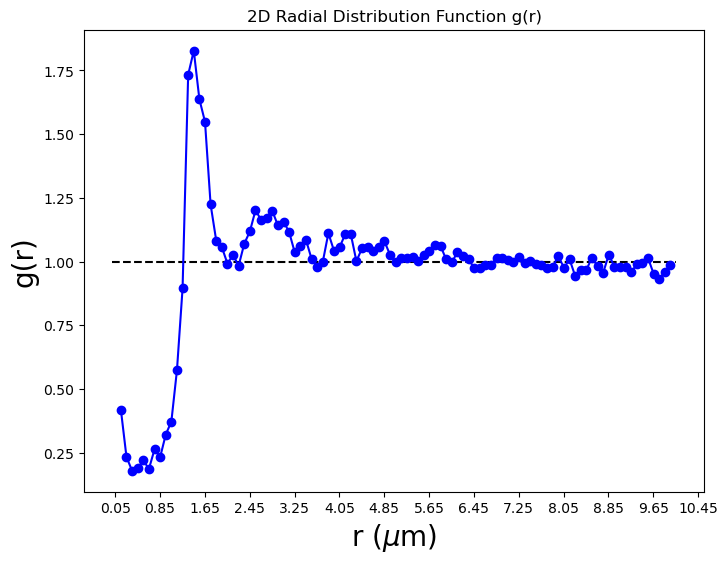

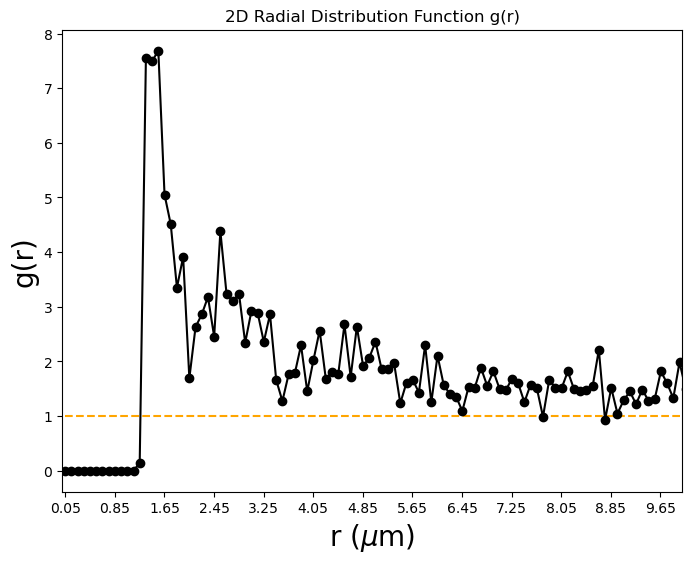

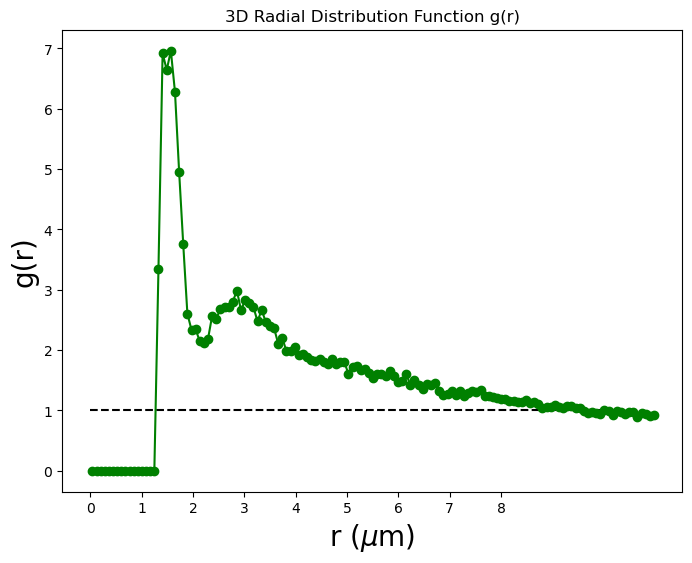

In [11]:
%matplotlib inline
start_bin = 1  # skip the first bin if needed

'''
max_idx = np.argmax(rdf_values[start_bin:]) + start_bin
max_idx_3D = np.argmax(rdf_values_3D[start_bin:]) + start_bin
max_r = radi[max_idx]
max_g = rdf_values[max_idx]
print(f"Maximum g(r) = {max_g:.3f} at r = {max_r:.3f} microns for 2D")
print(f"Maximum g(r) = {rdf_values_3D[max_idx_3D]:.3f} at r = {radi_3D[max_idx_3D]:.3f} microns for 3D")
'''

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, radi[100], 1))  # set x-ticks
plt.title('2D Radial Distribution Function g(r)')
plt.xticks(np.arange(radi[0],radi[len(radi)-1], 0.8))  # set x-ticks
plt.xlabel('r ($\mu$m)', fontsize = 20)
plt.ylabel('g(r)',fontsize = 20)
plt.plot([0, radi[100]], [1, 1], color='k', linestyle='--', label='Ideal gas')  # horizontal line at g(r) = 1
plt.plot(radi[1:100], rdf_values[1:100], marker='o', linestyle='-', color='b')

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(dists[0],dists[len(dists)-1], 0.8),fontsize = 10)  # set x-ticks
plt.title('2D Radial Distribution Function g(r)')
plt.xlabel('r ($\mu$m)', fontsize = 20)
plt.ylabel('g(r)',fontsize = 20)
plt.xlim(0,10)
plt.plot([dists[0],dists[659]], [1, 1], color='orange', linestyle='--', label='Ideal gas')  # horizontal line at g(r) = 1
plt.plot(dists, rdf_sliced, marker='o', linestyle='-', color='black')

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, radi_3D[100], 1))
plt.title('3D Radial Distribution Function g(r)')
plt.xlabel('r ($\mu$m)',fontsize = 20)
plt.ylabel('g(r)',fontsize = 20)
plt.plot([0, 10], [1, 1], color='k', linestyle='--', label='Ideal gas')  # horizontal line at g(r) = 1
plt.plot(radi_3D[:len(rdf_values_3D)], rdf_values_3D, marker='o', linestyle='-', color='green')



In [19]:
# compute and plot the structure factor
q_max = 8*math.pi/1.8 # maximum q value in 1/micron
N_bins = 30
nk_bound = 16
n = 1
k_values, sf_values = sf.S_q(positions, nk_bound, box_length, q_max, n, N_bins) # create the sf object
print(f'The structure factor is {sf_values}')

Total generated q-vectors: 32768
q-vector spacing in x, y, z: 0.05, 0.05, 0.25
q_max: 13.96
Number of q-vectors with |q| < q_max: 32768
The structure factor is [  0.         475.49971506 283.65945355 178.21664606 113.97138934
 117.11521333 127.73695565 143.08265987 178.22897294   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alesp\AppData\Local\Temp\ipykernel_18228\2855824267.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('q$\sigma$')


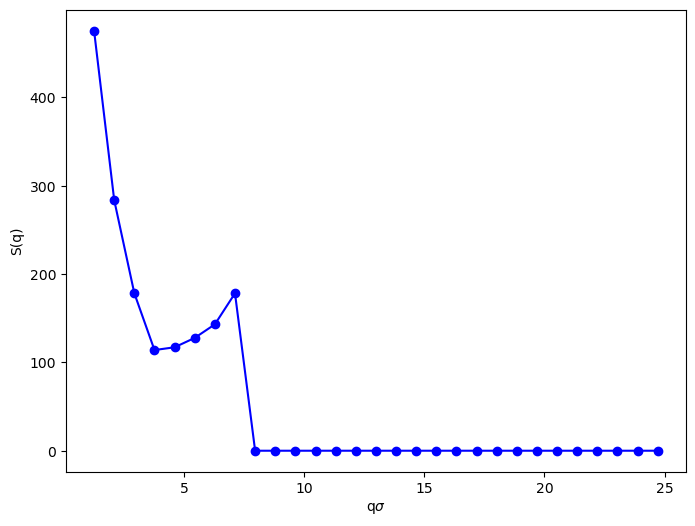

In [21]:
plt.figure(figsize=(8, 6))
plt.xlabel('q$\sigma$')
plt.ylabel('S(q)')
#plt.vlines(max_r, 0, np.max(rdf_values), colors='r', linestyles='--', label=f'{max_r} microns')  # vertical line at 1.5 microns
plt.plot(1.8*k_values[1:], sf_values[1:], marker='o', linestyle='-', color='b')

In [9]:
plots.draw_patches_in_box(patch_coo,box_length)

In [10]:
# Set here the parameters for building the network and reconstructing the shapes
diameter = 1.8  # in microns: 1.8 is the SEM value

dist_treshold = (diameter/2)*(4/math.sqrt(6)) # edge of the tethraedron (in microns)
#dist_treshold = max_r # in microns: we also tried to use the first peak of the g(r) of the patches for the networking
dist_tolerance_network = 1. # in microns 
dist_tolerance_triangles = 0.6

network,distances_in_network,vectors_in_network = mainf.make_network(patch_coo,dist_treshold,dist_tolerance_network)

target_angle = 60 # in degrees
ang_tolerance = 10. # in degrees

params_path = os.path.join(analysis_results_folder, 'parameters_shape.txt')
with open(params_path, 'w') as f:
    f.write(f"particle diameter: {diameter} microns\n")
    f.write(f"networking distance: {dist_treshold} microns\n")
    f.write(f"tolerance on networking: {dist_tolerance_network} microns\n")
    f.write(f"tolerance on triangle and tetrahedron: {dist_tolerance_triangles} microns\n")
    f.write(f"target angle {target_angle}degrees\n")
    f.write(f"angle tolerance {ang_tolerance}degrees\n")


# Here we compute the angles between the patch identifier and its neighbors
#all_angles = mainf.compute_angles_between_patches(vectors_in_network)

# Here we store the neighbors in a triangle and in tetraedrons + theirs distance vectors in dictionaries
triangles_neighbors, triangles_vectors, tetras_neighbors, tetras_vectors = mainf.find_shape(network,vectors_in_network,dist_treshold,dist_tolerance_triangles,target_angle,ang_tolerance)
cleaned_triangles_neighbors = mainf.remove_repeated(triangles_neighbors) # Remove duplicates
cleaned_tetras_neighbors = mainf.remove_repeated(tetras_neighbors) # Remove duplicates
fake_triangles = mainf.is_triangle_in_tetrahedron(cleaned_triangles_neighbors, cleaned_tetras_neighbors) # Check if the triangles are in the tetrahedrons

# Remove entries whose key is in fake_triangles
for tid in fake_triangles:
    if tid in cleaned_triangles_neighbors:
        del cleaned_triangles_neighbors[tid]
                
# Here we store the (top,bottom) patch recostructed from the triangles WITHOUT duplicates
from_triangles_to_tetras = mainf.reconstructed_tetras(patch_coo, cleaned_triangles_neighbors)

print(f"All the patches with neighbors {len(network)} (without eliminating duplicates)")
mainf.longest_key(network)

print(f"There are {len(fake_triangles)} fake triangles in the network and they are {fake_triangles}")
print(f"There are {len(cleaned_triangles_neighbors)} regular triangles in the network")
print(f'There are {len(cleaned_tetras_neighbors)} real tetrahedrons in the network')


All the patches with neighbors 2841 (without eliminating duplicates)
The key with the longest list is: 1465
The length of the longest list is: 7
The longest list is: [1070, 1078, 1218, 1370, 1372, 1375, 1600]
Length 1 occurs 992 times
Length 2 occurs 1014 times
Length 3 occurs 541 times
Length 4 occurs 226 times
Length 5 occurs 59 times
Length 6 occurs 7 times
Length 7 occurs 2 times
There are 73 fake triangles in the network and they are [14, 96, 141, 142, 165, 194, 212, 273, 325, 348, 351, 550, 559, 570, 615, 699, 708, 719, 741, 793, 939, 987, 1013, 1025, 1070, 1125, 1136, 1140, 1146, 1154, 1156, 1157, 1174, 1213, 1260, 1267, 1363, 1374, 1388, 1468, 1560, 1690, 1708, 1746, 1782, 1817, 1855, 1859, 1864, 1933, 1936, 2018, 2021, 2055, 2213, 2376, 2450, 2613, 2670, 2857, 2897, 2906, 2951, 2953, 2976, 3014, 3112, 3135, 3148, 3164, 3316, 3344, 3382]
There are 83 regular triangles in the network
There are 214 real tetrahedrons in the network


In [11]:
print(cleaned_tetras_neighbors)
print('---')
print(cleaned_triangles_neighbors)

{19: [[207, 321, 323]], 23: [[59, 62, 119]], 26: [[41, 141, 245]], 29: [[13, 112, 114]], 52: [[311, 314, 402]], 61: [[118, 230, 335]], 62: [[23, 119, 121]], 75: [[142, 143, 249]], 97: [[96, 308, 311]], 119: [[23, 62, 231]], 164: [[162, 267, 380]], 166: [[267, 268, 351]], 167: [[165, 269, 352]], 169: [[269, 272, 353]], 173: [[273, 274, 276]], 187: [[180, 292, 399]], 195: [[194, 197, 367]], 205: [[100, 206, 315]], 206: [[100, 205, 207]], 214: [[103, 220, 325]], 220: [[103, 214, 373]], 223: [[112, 114, 374]], 228: [[122, 125, 227]], 234: [[127, 128, 337]], 236: [[128, 237, 337]], 263: [[14, 81, 159]], 269: [[167, 169, 353]], 290: [[182, 383, 571]], 298: [[49, 190, 299]], 299: [[95, 190, 298]], 301: [[95, 190, 368]], 327: [[212, 215, 420]], 335: [[61, 117, 118]], 343: [[78, 424, 463]], 345: [[347, 348, 379]], 380: [[164, 267, 268]], 402: [[52, 313, 314]], 410: [[100, 207, 211]], 415: [[200, 473, 802]], 427: [[320, 597, 706]], 434: [[443, 646, 899]], 454: [[446, 453, 573]], 463: [[343, 424,

In [17]:
# Collect all unique patch IDs from the network dictionary
patch_ids = set(network.keys())
for neighbors in network.values():
    patch_ids.update(neighbors)

# Extract coordinates for each patch ID
points = []
for pid in patch_ids:
    if pid in patch_coo:
        points.append([pid] + patch_coo[pid])  # [ID, z, y, x]

# Create a DataFrame and save to CSV
points_df = pd.DataFrame(points, columns=['ID', 'z', 'y', 'x'])
points_csv_path = os.path.join(analysis_results_folder, 'network_points.csv')
points_df.to_csv(points_csv_path, index=False)
points_df

ID          z           y          x
0      1   1.980840   72.427246   2.422758
1      2   2.176408  128.785227  27.381613
2      3   2.466899   83.875163  28.346485
3      5   2.800234  120.393097   7.989029
4      6   3.184307   25.283573  14.554748
..   ...        ...         ...        ...
321  372  18.149621   99.186880  65.258002
322  377  20.494946   30.158231  73.271071
323  378  20.535061   31.530208  72.797556
324  381  22.369433   79.060899  66.948500
325  382  22.502547   80.724563  66.666456

[326 rows x 4 columns]

In [18]:
triangles = []
for patch_id, neighbors_list in cleaned_triangles_neighbors.items():
    for neighbors in neighbors_list:
        triangle_ids = [patch_id] + neighbors
        # Get coordinates for each vertex
        triangle_coords = [patch_coo[pid] for pid in triangle_ids]
        triangles.append(triangle_coords)

triangles_array = np.array(triangles)  # shape: (n_triangles, 3, 3)
np.save(os.path.join(analysis_results_folder, 'patches_in_triangles.npy'), triangles_array)
print(f'The triangles have been saved in {os.path.join(analysis_results_folder, "patches_in_triangles.npy")}')


tetrahedrons = []
for patch_id, neighbors_list in cleaned_tetras_neighbors.items():
    for neighbors in neighbors_list:
        tetras_ids = [patch_id] + neighbors
        # Get coordinates for each vertex
        tetras_coords = [patch_coo[pid] for pid in tetras_ids]
        tetrahedrons.append(tetras_coords)

tetrahedrons_array = np.array(tetrahedrons)  # shape: (n_triangles, 4, 4)
np.save(os.path.join(analysis_results_folder, 'patches_in_tetrahedrons.npy'), tetrahedrons_array)
print(f'The tetrahedrons have been saved in {os.path.join(analysis_results_folder, "patches_in_tetrahedrons.npy")}')

The triangles have been saved in C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_06_24\T=33,15to33,65_dm_30_zgap_0,15_after20h_bottom5_555\T=33,15to33,65_dm_30_zgap_0,15_after20h_bottom5_555.ome\results\patches_in_triangles.npy
The tetrahedrons have been saved in C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_06_24\T=33,15to33,65_dm_30_zgap_0,15_after20h_bottom5_555\T=33,15to33,65_dm_30_zgap_0,15_after20h_bottom5_555.ome\results\patches_in_tetrahedrons.npy


In [11]:
cluster_members, clusters_coordinates = mainf.clusters(network,patch_coo)

In [ ]:
# Check if the clusters() works fine
print(cluster_members[34])
print(network[34])
print(patch_coo[34])
print(clusters_coordinates[34])

[[90, 176, 281, 283]]
[90, 176, 281, 283]
[np.float64(2.9694184514371216), np.float64(99.48494289478974), np.float64(79.46806501105479)]
[[np.float64(2.9694184514371216), np.float64(99.48494289478974), np.float64(79.46806501105479)], [np.float64(3.2622355071097195), np.float64(101.64105740580092), np.float64(79.65058850375287)], [np.float64(3.52025061535019), np.float64(97.60515540389348), np.float64(79.38785276348177)], [np.float64(3.5522558118165946), np.float64(97.93699439492788), np.float64(77.7342525957916)], [np.float64(3.688181334751396), np.float64(99.88345493219887), np.float64(80.82668040414784)]]


In [16]:
shared_tetra_patches = mainf.is_shared(cleaned_tetras_neighbors)
#print(cleaned_tetras_neighbors[84])
#print(cleaned_tetras_neighbors[85])  
#print(cluster_members[470])
#print(cluster_members[351])


Tetrahedron 23 shares exactly one patch with 62: [119]
Tetrahedron 23 shares exactly one patch with 119: [62]
Tetrahedron 61 shares exactly one patch with 335: [118]
Tetrahedron 62 shares exactly one patch with 23: [119]
Tetrahedron 62 shares exactly one patch with 119: [23]
Tetrahedron 119 shares exactly one patch with 23: [62]
Tetrahedron 119 shares exactly one patch with 62: [23]
Tetrahedron 164 shares exactly one patch with 166: [267]
Tetrahedron 164 shares exactly one patch with 380: [267]
Tetrahedron 166 shares exactly one patch with 164: [267]
Tetrahedron 167 shares exactly one patch with 169: [269]
Tetrahedron 169 shares exactly one patch with 167: [269]
Tetrahedron 169 shares exactly one patch with 269: [353]
Tetrahedron 187 shares exactly one patch with 504: [399]
Tetrahedron 214 shares exactly one patch with 220: [103]
Tetrahedron 220 shares exactly one patch with 214: [103]
Tetrahedron 269 shares exactly one patch with 169: [353]
Tetrahedron 298 shares exactly one patch wit

In [21]:
print(shared_tetra_patches[0])
print(cleaned_tetras_neighbors[23])
print(cleaned_tetras_neighbors[62])
print(network[119])

[23, 62, 119]
[[59, 62, 119]]
[[23, 119, 121]]
[23, 62, 231]


In [20]:
candidate_of_six_ids = []
for i in range(len(shared_tetra_patches)):
    candidate_of_six_ids.append(shared_tetra_patches[i][2]) # take the shared patch id

cluster_length = 6
cluster_of_length_6 = {key: members for key, members in cluster_members.items() if len(members[0]) == cluster_length}
print(cluster_of_length_6)

bonds = []
for k in candidate_of_six_ids:
    if k in cluster_of_length_6:
        print(f"{k} is a key in cluster_of_length_6.")
        bonds.append(k)
    else:
        print(f"{k} is NOT a key in cluster_of_length_6.")

print(f"These are the bonding patches {sorted(bonds)}")


{382: [[275, 276, 278, 279, 444, 651]], 677: [[577, 582, 673, 780, 782, 788]], 729: [[484, 620, 728, 730, 816, 884]], 1043: [[1159, 1317, 1320, 1324, 1334, 1559]], 1317: [[928, 982, 1043, 1151, 1320, 1324]], 1773: [[1664, 1665, 1771, 2072, 2075, 2202]], 1830: [[1829, 1834, 1835, 1838, 1974, 1977]]}
119 is NOT a key in cluster_of_length_6.
62 is NOT a key in cluster_of_length_6.
118 is NOT a key in cluster_of_length_6.
119 is NOT a key in cluster_of_length_6.
23 is NOT a key in cluster_of_length_6.
62 is NOT a key in cluster_of_length_6.
23 is NOT a key in cluster_of_length_6.
267 is NOT a key in cluster_of_length_6.
267 is NOT a key in cluster_of_length_6.
267 is NOT a key in cluster_of_length_6.
269 is NOT a key in cluster_of_length_6.
269 is NOT a key in cluster_of_length_6.
353 is NOT a key in cluster_of_length_6.
399 is NOT a key in cluster_of_length_6.
103 is NOT a key in cluster_of_length_6.
103 is NOT a key in cluster_of_length_6.
353 is NOT a key in cluster_of_length_6.
190 is 

In [22]:
def characterize_clusters(cluster_members, cleaned_tetras_neighbors, cluster_length):
    '''
    First of all this function distinguish between isolated clusters and clusters with connections
    '''
    filtered_clusters = {key: members for key, members in cluster_members.items() if len(members[0]) == cluster_length}
    longer_clusters = {key: members for key, members in cluster_members.items() if len(members[0]) > cluster_length}
    isolated_clusters = {}
    branchings = []
    for cluster_id, members in filtered_clusters.items():
        for member in members[0]:
            neighbors = []
            other_members = []

            if member in cleaned_tetras_neighbors.keys():
                print(f'id of tetra {member}')
                neighbors = [n for sublist in cleaned_tetras_neighbors[member] for n in sublist]
                other_members = [m for m in members[0] if m != member] # members of the cluster that are not the id of the terahedron
                other_members = set(other_members) 
                neighbors = set(neighbors)
                intersection = (set(other_members) & set(neighbors)) # this gives me the common elements between the two sets
                print(f'cluster_id {cluster_id} members {members} tetra_neighbors {neighbors} of id {member} other_members {other_members} and intersection {intersection}')
                if (cluster_id in neighbors) and len(intersection) == 2:
                    candidate_branching = []
                    candidate_branching = list(set(other_members) - intersection) # this gives me the element that is not in the intersection

                    if candidate_branching[0] in longer_clusters.keys():
                        branchings.append(candidate_branching)
                    else:
                        isolated_clusters[cluster_id] = members
    return isolated_clusters, branchings

isolted_clusters, branchings = characterize_clusters(cluster_members, cleaned_tetras_neighbors, 4)
#characterize_clusters(cluster_members,4)

print(branchings)
print(isolted_clusters)

id of tetra 129
cluster_id 121 members [[124, 129, 563, 687]] tetra_neighbors {121, 124, 687} of id 129 other_members {563, 124, 687} and intersection {124, 687}
id of tetra 1244
cluster_id 123 members [[2, 125, 686, 1244]] tetra_neighbors {2, 123, 686} of id 1244 other_members {2, 125, 686} and intersection {2, 686}
id of tetra 6
cluster_id 140 members [[6, 9, 138, 141]] tetra_neighbors {138, 140, 573} of id 6 other_members {9, 138, 141} and intersection {138}
id of tetra 39
cluster_id 179 members [[39, 176, 857, 984]] tetra_neighbors {984, 857, 179} of id 39 other_members {176, 857, 984} and intersection {984, 857}
id of tetra 594
cluster_id 192 members [[195, 408, 594, 842]] tetra_neighbors {192, 43, 408} of id 594 other_members {408, 842, 195} and intersection {408}
id of tetra 99
cluster_id 527 members [[99, 101, 667, 1232]] tetra_neighbors {1232, 667, 527} of id 99 other_members {1232, 667, 101} and intersection {1232, 667}
id of tetra 378
cluster_id 586 members [[29, 378, 699, 9

In [16]:
# Plot of the triangles and patches
#print(f'The box is {box_length} microns')
#plots.draw_triangles(cleaned_triangles_neighbors, patch_coo, network, box_length)

In [14]:
# Plot the reconstructed tetraedrons
#plots.draw_tetrahedrons(cleaned_triangles_neighbors,patch_coo,network,from_triangles_to_tetras,box_length)

In [15]:
# Plot the real tetrahedrons ONLY
#plots.draw_real_tetraedrons(cleaned_tetras_neighbors, patch_coo, network, box_length)

In [11]:
plots.draw_real_tetrahedrons_and_triangles(tetras_neighbors, triangles_neighbors, patch_coo, network, box_length)

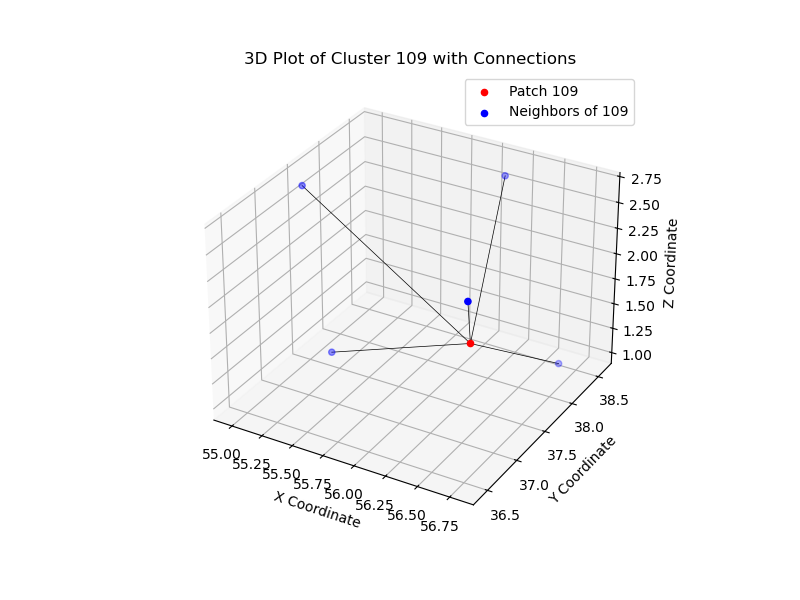

In [40]:
# Plot some clusters
def plot_cluster_with_lines(cluster_coordinates, cluster_id):
    """
    Plots a 3D cluster using its coordinates (in z, y, x order) and connects the points with lines.
    
    Args:
        cluster_coordinates (dict): Dictionary containing cluster coordinates.
                                    Format: {cluster_id: [[z1, y1, x1], [z2, y2, x2], ...]}
        cluster_id (int): The ID of the cluster to plot.
    """
    if cluster_id not in cluster_coordinates:
        print(f"Cluster ID {cluster_id} not found in cluster_coordinates.")
        return

    # Extract the coordinates of the cluster
    coordinates_id = cluster_coordinates[cluster_id]
    coordinates_id = coordinates_id[0]  # Main patch (red point)
    neighbors = cluster_coordinates[cluster_id][1:]  # Neighbors (blue points)

    # Unpack the main patch coordinates (z, y, x)
    z_i, y_i, x_i = coordinates_id

    # Unpack the neighbors' coordinates (z, y, x)
    z, y, x = zip(*neighbors)

    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the cluster points
    ax.scatter(x_i, y_i, z_i, c='red', marker='o', label=f'Patch {cluster_id}')  # Main patch
    ax.scatter(x, y, z, c='blue', marker='o', label=f'Neighbors of {cluster_id}')  # Neighbors

    # Connect the main patch to each neighbor
    for z_n, y_n, x_n in neighbors:
        ax.plot(
            [x_i, x_n], [y_i, y_n], [z_i, z_n],
            color='black', linestyle='-', linewidth=0.5
        )

    # Connect the neighbors to each other
    #for i in range(len(neighbors)):
     #   for j in range(i + 1, len(neighbors)):
      #      ax.plot(
       #         [neighbors[i][2], neighbors[j][2]],  # x-coordinates
        #        [neighbors[i][1], neighbors[j][1]],  # y-coordinates
         #       [neighbors[i][0], neighbors[j][0]],  # z-coordinates
          #      color='blue', linestyle='--', linewidth=0.5
           # )

    # Add labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title(f'3D Plot of Cluster {cluster_id} with Connections')
    ax.legend()

    # Show the plot
    plt.show()

# Example usage
# Assuming clusters_coordinates is already defined
plot_cluster_with_lines(clusters_coordinates, cluster_id=109)

In [18]:
plots.plot_clusters_with_labels(patch_coo,cluster_members,box_length)

[[ 0.51961524  0.51961524  0.51961524]
 [-0.51961524 -0.51961524  0.51961524]
 [-0.51961524  0.51961524 -0.51961524]
 [ 0.51961524 -0.51961524 -0.51961524]]
the square giration radius is 0.8100000000000002


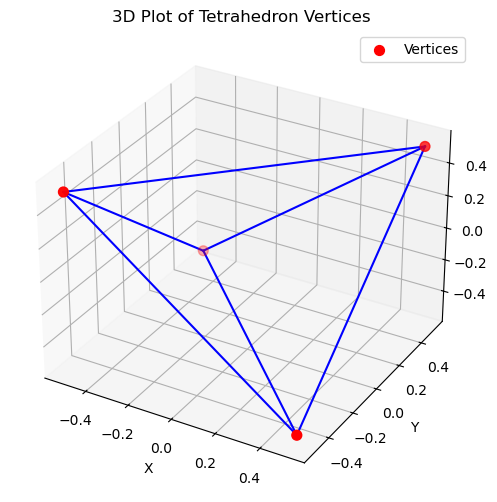

In [ ]:
dim = 1.8 # in mum
# Calcolare il raggio di girazione di un tetraedro regolare
vettori = np.array([
        [ 1,  1,  1],
        [-1, -1,  1],
        [-1,  1, -1],
        [ 1, -1, -1]
    ])
vertici = (vettori / np.linalg.norm(vettori, axis=1, keepdims=True))*(dim/2)

print(vertici)
Rg2 = 0.0
for i in range(len(vertici)):
    for j in range(i+1,len(vertici)):
        Rg2 += sum((vertici[i] - vertici[j])**2)

Rg2 = Rg2/len(vertici)**2
print(f'the square giration radius is {Rg2}') # comunque, essendo un tetraedro regolare, Rg è 6 volte il lato al quadrato diviso 16       

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the vertices
ax.scatter(vertici[:, 0], vertici[:, 1], vertici[:, 2], c='red', s=50, label='Vertices')

# Connect the vertices to form the edges of the tetrahedron
edges = [
    (0, 1), (0, 2), (0, 3),  # Edges from the first vertex
    (1, 2), (1, 3),          # Edges from the second vertex
    (2, 3)                   # Edges from the third vertex
]
for edge in edges:
    ax.plot(
        [vertici[edge[0], 0], vertici[edge[1], 0]],
        [vertici[edge[0], 1], vertici[edge[1], 1]],
        [vertici[edge[0], 2], vertici[edge[1], 2]],
        color='blue'
    )

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Tetrahedron Vertices')
ax.legend()

# Show the plot
plt.show()

From here on we find the centers from the real tetrahedrons and the reconstructed ones

In [14]:
fake_centers, real_centers = mainf.find_centers(cleaned_tetras_neighbors, cleaned_triangles_neighbors, from_triangles_to_tetras, patch_coo) # compute the centers of the tetrahedrons


centers = []
centers_top_vertex = []
centers_bottom_vertex = []

for identifier, center_list in real_centers.items():
    for center in center_list:
        centers.append((identifier, *center))  # Unpack the identifier and coordinates

for identifier, centers_list in fake_centers.items():
    for top, bottom in centers_list:
        centers_top_vertex.append([identifier, *top])  # Add identifier and top vertex coordinates
        centers_bottom_vertex.append([identifier, *bottom])  # Add identifier and bottom vertex coordinates



centers_df = pd.DataFrame(centers, columns=['ID','x','y','z']) # create a dataframe with the centers of the tetrahedrons
top_centers_df = pd.DataFrame(centers_top_vertex, columns=['ID','x','y','z']) # create a dataframe with the centers of the 'top' tetrahedrons
bottom_centers_df = pd.DataFrame(centers_bottom_vertex, columns=['ID','x','y','z']) # create a dataframe with the centers of the 'bottom' tetrahedrons

centers_df_path = os.path.join(analysis_results_folder,'real_centers' + timestr + '.csv')
top_centers_df_path = os.path.join(analysis_results_folder,'top_centers' + timestr + '.csv')
bottom_centers_df_path = os.path.join(analysis_results_folder,'bottom_centers' + timestr + '.csv')

centers_df.to_csv(centers_df_path, index=False) # save the coordinates of the patches in a csv file
top_centers_df.to_csv(top_centers_df_path, index=False) 
bottom_centers_df.to_csv(bottom_centers_df_path, index=False)


In [15]:
real_top_merged_df = pd.concat([centers_df, top_centers_df]) # create a dataframe with the centers of: real tetrahedrons+tetra from top vertex of the fake tetrahedrons
real_bottom_merged_df = pd.concat([centers_df, bottom_centers_df]) # create a dataframe with the centers of: real tetrahedrons+tetra from bottom vertex of the fake tetrahedrons
top_bottom_merged_df = pd.concat([top_centers_df, bottom_centers_df]) # create a dataframe with the centers of: tetra from top vertex+tetra from bottom vertex
real_top_merged_df = real_top_merged_df.sort_values(by='ID').reset_index(drop=True)
real_bottom_merged_df = real_bottom_merged_df.sort_values(by='ID').reset_index(drop=True)
top_bottom_merged_df = top_bottom_merged_df.sort_values(by='ID').reset_index(drop=True)


real_top_merged_df

ID          x          y         z
0      0  13.935129   4.612392  1.720829
1      1  50.770782   6.119698  1.948835
2      2  26.267595  13.109792  1.717530
3      3  40.036340  13.270364  1.893243
4      4  12.610857  13.596733  1.699583
..   ...        ...        ...       ...
189  682  58.048204  64.258356  3.575482
190  710  72.411649  44.225124  4.887787
191  730  11.142159   8.688725  4.933264
192  739  17.166990  68.821855  5.450319
193  748  72.658483  43.768456  5.341731

[194 rows x 4 columns]

In [16]:
tolerance = 0.1 # in microns
# Check overlap between real tetras
non_overlapping_particles,overlapping_ids = mainf.check_particles_overlap(diameter,centers_df,tolerance) 
# Check overlap between top tetras-top tetras and bottom tetras-bottom tetras
non_overlapping_particles_top = mainf.check_particles_overlap(diameter,top_centers_df,tolerance)[0]
non_overlapping_particles_bottom = mainf.check_particles_overlap(diameter,bottom_centers_df,tolerance)[0]
# Check overlap between real tetras and top tetras
real_non_overlapping_top = pd.concat([non_overlapping_particles, non_overlapping_particles_top]) # create a dataframe with the centers of: real tetrahedrons+tetra from top vertex of the fake tetrahedrons
real_non_overlapping_top = real_non_overlapping_top.sort_values(by='ID').reset_index(drop=True)
non_overlapping_particles_real_top = mainf.check_particles_overlap(diameter,real_non_overlapping_top,tolerance)[0]
# Check overlap between real tetras and bottom tetras
real_non_overlapping_bottom = pd.concat([non_overlapping_particles, non_overlapping_particles_bottom]) # create a dataframe with the centers of: real tetrahedrons+tetra from top vertex of the fake tetrahedrons
real_non_overlapping_bottom = real_non_overlapping_bottom.sort_values(by='ID').reset_index(drop=True)
non_overlapping_particles_real_bottom = mainf.check_particles_overlap(diameter,real_non_overlapping_bottom,tolerance)[0]
# Check overlap between top tetras and bottom tetras
non_overlapping_particles_top_bottom = mainf.check_particles_overlap(diameter,top_bottom_merged_df,tolerance)[0]


Overlap detected between 32 and 403 with distance radius 0.63 < radius 1.80
Overlap detected between 32 and 404 with distance radius 0.36 < radius 1.80
Overlap detected between 94 and 431 with distance radius 1.14 < radius 1.80
Overlap detected between 95 and 577 with distance radius 1.19 < radius 1.80
Overlap detected between 101 and 142 with distance radius 1.63 < radius 1.80
Overlap detected between 106 and 464 with distance radius 0.35 < radius 1.80
Overlap detected between 107 and 149 with distance radius 0.87 < radius 1.80
Overlap detected between 112 and 416 with distance radius 0.63 < radius 1.80
Overlap detected between 126 and 488 with distance radius 1.29 < radius 1.80
Overlap detected between 242 and 639 with distance radius 0.71 < radius 1.80
Overlap detected between 403 and 404 with distance radius 0.45 < radius 1.80
Overlap detected between 420 and 569 with distance radius 1.07 < radius 1.80
Overlap detected between 436 and 535 with distance radius 0.60 < radius 1.80
Ove

In [17]:
print(f'There are {len(non_overlapping_particles)} non overlapping REAL particles')
print(f'There are {len(non_overlapping_particles_top)} non overlapping TOP particles')
print(f'There are {len(non_overlapping_particles_bottom)} non overlapping BOTTOM particles')
print(f'There are {len(non_overlapping_particles_real_top)} non overlapping REAL TOP particles')
print(f'There are {len(non_overlapping_particles_real_bottom)} non overlapping REAL BOTTOM particles')
print(f'There are {len(non_overlapping_particles_top_bottom)} non overlapping TOP and BOTTOM particles')

There are 90 non overlapping REAL particles
There are 49 non overlapping TOP particles
There are 45 non overlapping BOTTOM particles
There are 109 non overlapping REAL TOP particles
There are 107 non overlapping REAL BOTTOM particles
There are 0 non overlapping TOP and BOTTOM particles


In [18]:
non_overlapping_particles['label'] = 'real'
non_overlapping_particles_top['label'] = 'top+top'
non_overlapping_particles_bottom['label'] = 'bottom+bottom'
non_overlapping_particles_real_top['label'] = 'real+top'
non_overlapping_particles_real_bottom['label'] = 'real+bottom'
non_overlapping_particles_top_bottom['label'] = 'top+bottom'

non_overlapping_particles_real_bottom

ID          x          y         z        label
0      0  13.935129   4.612392  1.720829  real+bottom
1      1  50.770782   6.119698  1.948835  real+bottom
2      2  26.267595  13.109792  1.717530  real+bottom
3      5  22.929586  17.078956  1.628172  real+bottom
4      6  41.310313  25.756894  1.525501  real+bottom
..   ...        ...        ...       ...          ...
102  660  44.395904  27.161249  4.231155  real+bottom
103  664  61.668027  48.069410  4.040176  real+bottom
104  681  51.587960  52.552679  3.272423  real+bottom
105  730  11.239448   9.224009  4.666212  real+bottom
106  739  16.669178  68.368205  5.282676  real+bottom

[107 rows x 5 columns]

In [19]:
all_centers = pd.concat([non_overlapping_particles, non_overlapping_particles_top, non_overlapping_particles_bottom, non_overlapping_particles_real_top, non_overlapping_particles_real_bottom], ignore_index=True)
all_centers = all_centers.sort_values(by='ID').reset_index(drop=True)
all_centers_path = os.path.join(analysis_results_folder,'all_centers'+timestr+'.csv')
all_centers.to_csv(all_centers_path, index = False)
all_centers


ID          x          y         z          label
0      0  13.935129   4.612392  1.720829    real+bottom
1      0  13.935129   4.612392  1.720829           real
2      0  13.935129   4.612392  1.720829       real+top
3      1  50.770782   6.119698  1.948835    real+bottom
4      1  50.770782   6.119698  1.948835           real
..   ...        ...        ...       ...            ...
395  739  17.166990  68.821855  5.450319        top+top
396  739  16.669178  68.368205  5.282676  bottom+bottom
397  739  17.166990  68.821855  5.450319       real+top
398  748  72.658483  43.768456  5.341731        top+top
399  748  72.364362  44.234701  5.016324  bottom+bottom

[400 rows x 5 columns]

In [20]:
atom = all_centers['label'].to_list()

In [21]:
def dataframe_to_xyz(df, filename):
    label_map = {
        'real': 'real_with_real',
        'real+top': 'real_with_top',
        'real+bottom': 'real_with_bottom',
        'top+top': 'top_with_top',
        'bottom+bottom': 'bottom_with_bottom',
    }
    
    n_atoms = len(df)
    
    with open(filename, 'w') as f:
        f.write(f"{n_atoms}\n")
        f.write("Generated by dataframe_to_xyz\n")  # Comment line
        
        for _, row in df.iterrows():
            label = label_map.get(row['label'], 'X')  # Default to 'X' if unknown
            f.write(f"{label} {row['x']} {row['y']} {row['z']}\n")


dataframe_to_xyz(all_centers, 'all_centers(2).xyz')

In [20]:
#radius = diameter/2
#plots.draw_spheres_from_dataframe(all_centers,radius,box_length) watch out che crasha tutto diomadonna